In [1]:
print "Start"
import random
from pyspark import SparkContext
sc =SparkContext.getOrCreate()
print(sc._jsc.sc().getExecutorMemoryStatus())
hdfsPath = "hdfs://115.146.92.120:9000/user/ubuntu/"

Start
Map(115.146.93.195:38621 -> (2887149158,2887149158), 115.146.92.120:43351 -> (2887149158,2887149158), 115.146.92.120:41961 -> (384093388,384093388), 115.146.92.103:35778 -> (2887149158,2887149158), 115.146.92.14:40989 -> (2887149158,2887149158))


In [2]:
import pyspark.sql.functions as func
from pyspark.sql.functions import desc
from pyspark.sql.functions import col

import pandas
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


In [3]:
AllTweets = spark.read.json(hdfsPath + "newBigTweets.json")
AllTweets = AllTweets.withColumnRenamed("doc", "json")


In [4]:
AllTweetsFromPortMelbourne = AllTweets.filter((col("json.geo.coordinates")[1] >=  144.91469672)
                 & (col("json.geo.coordinates")[1] <=  144.94976819)
                 & (col("json.geo.coordinates")[0] >=  -37.84721681)
                 & (col("json.geo.coordinates")[0] <=  -37.83061846)
                 )
AllTweetsFromPortMelbourne.count()

2576

In [5]:
FilteredTweeters = AllTweetsFromPortMelbourne.groupBy("json.user.screen_name").agg(func.count(func.lit(1)).alias("Num Of Tweets")).filter("`Num Of Tweets` > 10 and `Num Of Tweets` < 2000").sort(desc("`Num Of Tweets`"))
FilteredTweeters.show()

+---------------+-------------+
|    screen_name|Num Of Tweets|
+---------------+-------------+
| emgw_melbourne|           85|
|WintourGuinness|           83|
|   mrlawrencepm|           57|
|         VivPel|           53|
|         volk10|           45|
|  itsybitsychef|           45|
|   pdjenkins007|           32|
|          dee2x|           32|
|    DamienBean5|           31|
|      melleegee|           30|
|         Li_Ras|           28|
|        DrRossH|           27|
|   Ella9908Ross|           25|
|        PMQ5311|           24|
|    Brendan2601|           23|
|Allan_McFarlane|           23|
|         G1NCHY|           22|
|Fitness_Travels|           19|
|  decanterswine|           19|
|    andylamrock|           18|
+---------------+-------------+
only showing top 20 rows



In [23]:
FilteredTweeters.count()

40

In [6]:
filteredNames = FilteredTweeters.select("screen_name").collect()
filteredNamesList = []
for name in filteredNames:
    filteredNamesList.append(name["screen_name"])

In [7]:
filteredTweets = AllTweetsFromPortMelbourne.filter(col("json.user.screen_name").isin(filteredNamesList))

In [8]:
spark.catalog.clearCache()
filteredTweets.cache()


DataFrame[_corrupt_record: string, json: struct<_id:string,_rev:string,contributors:string,coordinates:struct<coordinates:array<double>,type:string>,created_at:string,entities:struct<hashtags:array<struct<indices:array<bigint>,text:string>>,media:array<struct<display_url:string,expanded_url:string,id:bigint,id_str:string,indices:array<bigint>,media_url:string,media_url_https:string,sizes:struct<large:struct<h:bigint,resize:string,w:bigint>,medium:struct<h:bigint,resize:string,w:bigint>,small:struct<h:bigint,resize:string,w:bigint>,thumb:struct<h:bigint,resize:string,w:bigint>>,source_status_id:bigint,source_status_id_str:string,source_user_id:bigint,source_user_id_str:string,type:string,url:string>>,symbols:array<struct<indices:array<bigint>,text:string>>,urls:array<struct<display_url:string,expanded_url:string,indices:array<bigint>,url:string>>,user_mentions:array<struct<id:bigint,id_str:string,indices:array<bigint>,name:string,screen_name:string>>>,extended_entities:struct<media:arra

In [9]:
filteredTweets.count()

998

In [10]:
with open('/home/ubuntu/PortMelbourneProperties.bin', 'r') as f:
    PortMelbourneProperties = pickle.load(f)

In [11]:
i=0
for prop in PortMelbourneProperties:
    i+=1
    filteredTweetsIn = filteredTweets.filter((col("json.geo.coordinates")[0] >=  prop["viewport"]['southwest']['lat'])
                 & (col("json.geo.coordinates")[0] <=  prop["viewport"]['northeast']['lat'])
                 & (col("json.geo.coordinates")[1] <=  prop["viewport"]['northeast']['lng'])
                 & (col("json.geo.coordinates")[1] >=  prop["viewport"]['southwest']['lng'])
                 )
    prop["TweetCount"] = filteredTweetsIn.count()
    prop["UniqueTweeters"] = filteredTweetsIn.groupBy("json.user.screen_name").agg(func.count(func.lit(1)).alias("Num Of Tweets")).collect()
    prop["UniqueTweetersCount"] = len(prop["UniqueTweeters"])
    print(i,prop["TweetCount"],len(prop["UniqueTweeters"]),prop["CL_Bedrooms"])

    

with open('/home/ubuntu/PortMelbournePropertiesWithTweets.bin', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump(PortMelbourneProperties, f)

(1, 168, 14, 39)
(2, 179, 14, 35)
(3, 2, 2, 35)
(4, 33, 4, 33)
(5, 34, 9, 26)
(6, 121, 7, 23)
(7, 82, 14, 23)
(8, 178, 14, 21)
(9, 195, 9, 19)
(10, 15, 4, 15)
(11, 2, 2, 12)
(12, 33, 4, 12)
(13, 135, 8, 12)
(14, 190, 11, 12)
(15, 21, 3, 11)
(16, 81, 6, 11)
(17, 179, 15, 11)
(18, 96, 15, 10)
(19, 180, 12, 9)
(20, 0, 0, 9)
(21, 17, 3, 9)
(22, 25, 4, 8)
(23, 24, 2, 8)
(24, 48, 13, 7)
(25, 81, 6, 6)
(26, 60, 8, 6)
(27, 190, 11, 6)
(28, 183, 13, 6)
(29, 24, 2, 6)
(30, 173, 15, 6)
(31, 175, 14, 6)
(32, 21, 3, 5)
(33, 181, 14, 5)
(34, 142, 19, 5)
(35, 107, 14, 5)
(36, 181, 14, 5)
(37, 168, 14, 5)
(38, 94, 15, 5)
(39, 37, 9, 5)
(40, 183, 15, 5)
(41, 27, 7, 5)
(42, 126, 10, 5)
(43, 181, 14, 4)
(44, 8, 2, 4)
(45, 87, 9, 4)
(46, 48, 13, 4)
(47, 0, 0, 4)
(48, 214, 13, 4)
(49, 0, 0, 4)
(50, 1, 1, 4)
(51, 82, 14, 4)
(52, 1, 1, 4)
(53, 2, 1, 4)
(54, 15, 1, 4)
(55, 94, 15, 4)
(56, 9, 7, 4)
(57, 63, 16, 4)
(58, 181, 14, 4)
(59, 13, 3, 3)
(60, 14, 2, 3)
(61, 33, 4, 3)
(62, 156, 12, 3)
(63, 31, 7, 3)
(64

(525, 2, 2, 1)
(526, 37, 9, 1)
(527, 2, 2, 1)
(528, 0, 0, 1)
(529, 1, 1, 1)
(530, 43, 8, 1)
(531, 0, 0, 1)
(532, 4, 4, 1)
(533, 14, 3, 1)
(534, 107, 10, 1)
(535, 5, 4, 1)
(536, 2, 1, 1)
(537, 195, 9, 1)
(538, 44, 10, 1)
(539, 173, 12, 1)
(540, 9, 3, 1)
(541, 37, 8, 1)
(542, 13, 7, 1)
(543, 4, 1, 1)
(544, 1, 1, 1)
(545, 80, 11, 1)
(546, 5, 3, 1)
(547, 2, 2, 1)
(548, 54, 7, 1)
(549, 20, 5, 1)
(550, 15, 4, 1)
(551, 60, 10, 1)
(552, 40, 4, 1)
(553, 74, 10, 1)
(554, 2, 2, 1)
(555, 4, 3, 1)
(556, 46, 2, 1)
(557, 2, 1, 1)
(558, 2, 1, 1)
(559, 0, 0, 1)
(560, 37, 9, 1)
(561, 121, 7, 1)
(562, 45, 2, 1)
(563, 1, 1, 1)
(564, 173, 13, 1)
(565, 10, 6, 1)
(566, 34, 9, 1)
(567, 1, 1, 1)
(568, 0, 0, 1)
(569, 34, 7, 1)
(570, 33, 4, 1)
(571, 12, 2, 1)
(572, 43, 8, 1)
(573, 0, 0, 1)
(574, 6, 4, 1)
(575, 2, 1, 1)
(576, 196, 14, 1)
(577, 2, 1, 1)
(578, 15, 3, 1)
(579, 12, 2, 1)
(580, 2, 2, 1)
(581, 35, 8, 1)
(582, 15, 3, 1)
(583, 5, 2, 1)
(584, 1, 1, 1)
(585, 32, 6, 1)
(586, 36, 2, 1)
(587, 14, 3, 1)
(588, 

In [36]:
from collections import OrderedDict
from datetime import date

df = pandas.DataFrame(PortMelbourneProperties)
df = df.groupby('viewport', group_keys=False).apply(lambda x: x.ix[x.TweetCount.idxmax()])

NameError: name 'explode' is not defined

In [13]:
df.sample(n=4)

,CL_Bedrooms,TweetCount,UniqueTweeters,UniqueTweetersCount,coordinates,viewport
629,1,0,[],0,"[144.94305466, -37.84103116]","{u'northeast': {u'lat': -37.8397192197, u'lng'..."
101,2,0,[],0,"[144.94300878, -37.84203743]","{u'northeast': {u'lat': -37.8405302197, u'lng'..."
244,1,2,"[(suntanxxx, 2)]",1,"[144.94601882, -37.83673841]","{u'northeast': {u'lat': -37.8353787697, u'lng'..."
154,1,1,"[(VickyRood, 1)]",1,"[144.93648468, -37.8359384]","{u'northeast': {u'lat': -37.8345620197, u'lng'..."


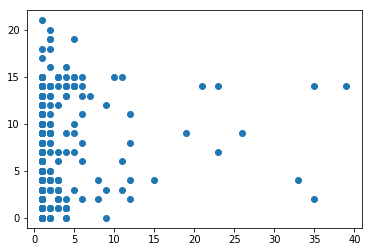

In [14]:
plt.scatter(df["CL_Bedrooms"], df["UniqueTweetersCount"])

In [37]:
filteredTweetersVsBedrooms = df[(df.UniqueTweetersCount==1) & (df.CL_Bedrooms ==1)]

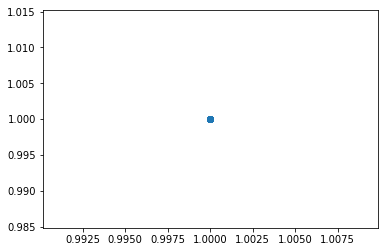

In [38]:
plt.scatter(filteredTweetersVsBedrooms["CL_Bedrooms"], filteredTweetersVsBedrooms["UniqueTweetersCount"])

In [42]:
filteredTweetersVsBedrooms.sort_values(by = "TweetCount",ascending=False)

,CL_Bedrooms,TweetCount,UniqueTweeters,UniqueTweetersCount,coordinates,viewport
295,1,17,"[(samdubyna, 17)]",1,"[144.92732143, -37.83636571]","{u'northeast': {u'lat': -37.8350050197, u'lng'..."
125,1,15,"[(portpickle, 15)]",1,"[144.9282598, -37.8388332]","{u'northeast': {u'lat': -37.8375230197, u'lng'..."
671,1,15,"[(portpickle, 15)]",1,"[144.92888153, -37.83893984]","{u'northeast': {u'lat': -37.8376514197, u'lng'..."
651,1,15,"[(portpickle, 15)]",1,"[144.92854108, -37.83988839]","{u'northeast': {u'lat': -37.8385394197, u'lng'..."
614,1,14,"[(portpickle, 14)]",1,"[144.92917717, -37.83887599]","{u'northeast': {u'lat': -37.8375270197, u'lng'..."
490,1,14,"[(andrew_whalan, 14)]",1,"[144.92648684, -37.83817312]","{u'northeast': {u'lat': -37.8367744197, u'lng'..."
438,1,14,"[(portpickle, 14)]",1,"[144.92914674, -37.83940142]","{u'northeast': {u'lat': -37.8380544197, u'lng'..."
398,1,12,"[(soopteller, 12)]",1,"[144.94745197, -37.8326567]","{u'northeast': {u'lat': -37.8313220197, u'lng'..."
458,1,8,"[(emgw_melbourne, 8)]",1,"[144.93423625, -37.83944147]","{u'northeast': {u'lat': -37.8381010197, u'lng'..."
217,1,7,"[(melleegee, 7)]",1,"[144.94532599, -37.84542496]","{u'northeast': {u'lat': -37.8440809197, u'lng'..."


In [43]:
alreadSeenViewPorts = []
i = 0 
for prop in PortMelbourneProperties:
    if prop["viewport"] in alreadSeenViewPorts:
        
        i+=1
    else:
        alreadSeenViewPorts.append(prop["viewport"])
print(i)

99


In [24]:
len(PortMelbourneProperties)

681